In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run tools.py

ERROR:root:File `'tools.py'` not found.


In [3]:
muts = pd.read_csv("../../resources/exampleMutations.tsv", sep="\t")
muts = muts.iloc[:16] # no sap markers busia data

muts['chrom'] = muts['Location'].str.split(":").str.get(0)
muts['pos'] = muts['Location'].str.split(":").str.get(1).str.split("-").str.get(0)
muts = muts.sort_values(['chrom', 'pos'])

In [4]:
Path = "../../results/variantAnalysis/variantsOfInterest/csvs/{mut}_alleleBalance.csv"
mean_ = False
var='sample'

In [84]:
freqDict = {}
covDict = {}

for mut in muts['Name']:
    df = pd.read_csv(Path.format(mut=mut))
    if mean_:
        df['gene'] = muts[muts.Name == mut]['Gene'].iloc[0]
    df['name'] = df['chrom'] + ":"+ df['pos'].astype(str) + "  " + df['gene'] + " | " + df['mutation']
    df['frequency'] = df.filter(like="proportion").sum(axis=1)
    freqDict[mut] = df[['name', var, 'frequency']]
    covDict[mut] = df[['name', var, 'cov']]

voiData = pd.concat(freqDict)
covData = pd.concat(covDict)
voiFreqTable = voiData.pivot(index="name", columns=var).round(2).droplevel(0, axis=1) 
voiCovTable = covData.pivot(index="name", columns=var).round(2).droplevel(0, axis=1)

#annotTable = (voiFreqTable*100).astype(int).astype(str) + "%" ## percentages
annotTable = voiFreqTable.astype(str).apply(lambda x: x.str.strip("0")).applymap(addZeros)  ## decimals

In [97]:
lowCov = 10

## adding asterisks if low Cov 
asteriskTable = voiCovTable.applymap(lambda x: "*" if x < lowCov else "")
annotTable = annotTable + asteriskTable
annotTable = annotTable.applymap(lambda x: "" if x == "*" else x)

In [96]:
plotRectangular(voiFreqTable, annot=annotTable, path="test.png", dpi=200)

### Normal plots

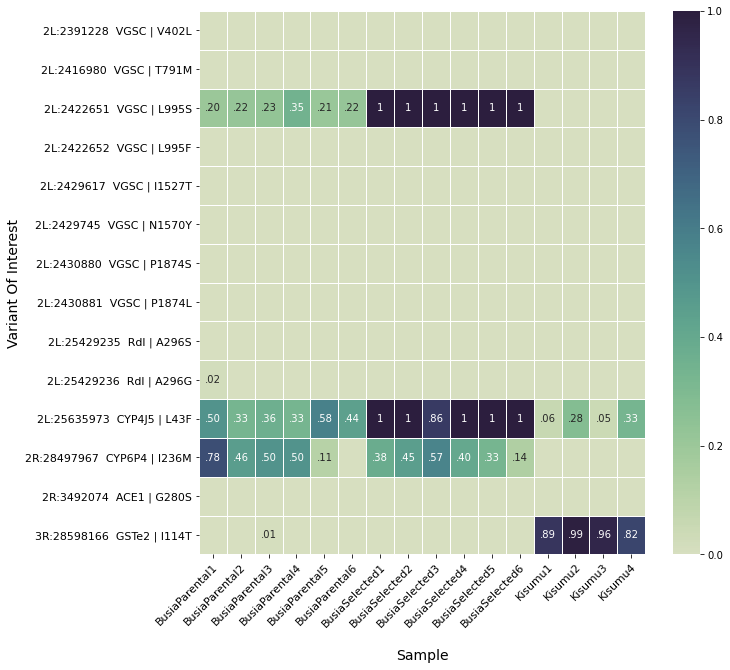

In [15]:
muts = muts.query("Gene != 'COEAE1F'")

df, annot = getAlleleFreqTable(muts, "../../results/variantAnalysis/variantsOfInterest/csvs/{mut}_alleleBalance.csv")
plotRectangular(df, annot=annot, path="../../results/variantAnalysis/variantsOfInterest/VOI.heatmapPerSample.png", dpi=200)

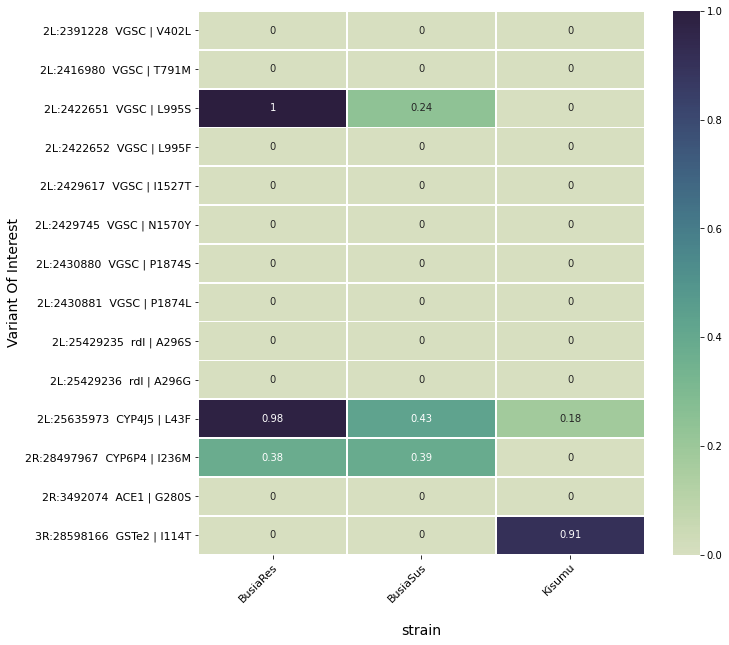

In [192]:
df = getAlleleFreqTable(muts, "../../results/variantAnalysis/variantsOfInterest/csvs/mean_{mut}_alleleBalance.csv", "treatment", mean_=True)
plotRectangular(df, path="../../results/variantAnalysis/variantsOfInterest/VOI.heatmapPerTreatment.png", xlab="strain", dpi=200)

### Summary Stats plots

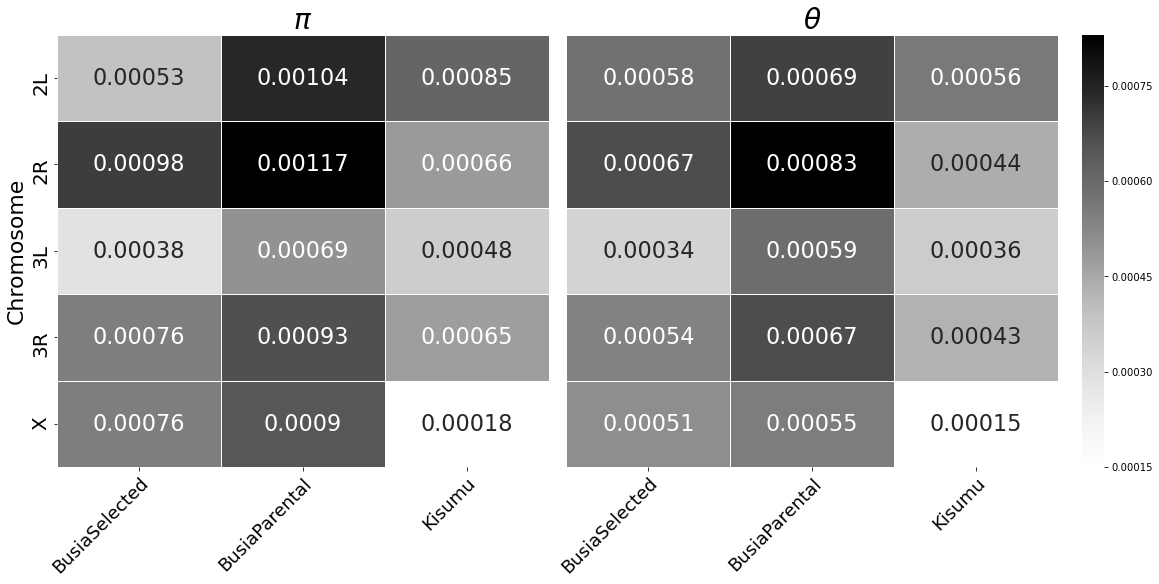

In [15]:
theta = pd.read_csv("../../results/variantAnalysis/diversity/WattersonsTheta.tsv", sep="\t", index_col=0).astype("float64").round(5)
pi = pd.read_csv("../../results/variantAnalysis/diversity/SequenceDiversity.tsv", sep="\t", index_col=0).astype("float64").round(5)

#plotRectangular(theta, path="test", figsize=[5,5], title=r'$\theta$', cmap="Greys")
#plotRectangular(pi, path="test", figsize=[5,5], title=r'$\pi$', cmap="Greys", ylab="Chromosome")

plotTwoRectangular(pi, True, theta, True, path=None, figsize=[16,8], title1=r'$\pi$', title2=r'$\theta$', ylab="Chromosome", ytickfontsize=20, ylabfontsize=22, cmap="Greys")
plt.show()

In [16]:
thetamean = theta.apply(np.mean, axis=0)
pimean = pi.apply(np.mean, axis=0)

summmaryStats = pd.DataFrame({r'$\theta$':thetamean, r'$\pi$':pimean})
summmaryStats

,$\theta$,$\pi$
BusiaSelected,0.000528,0.000682
BusiaParental,0.000666,0.000946
Kisumu,0.000388,0.000564


In [22]:
summmaryStats = summmaryStats.round(5)

In [34]:
theta = pd.DataFrame(summmaryStats.iloc[:,0])
pi = pd.DataFrame(summmaryStats.iloc[:,1])

plotTwoRectangular(pi, True, theta, True, path=None, cmap="Greys", figsize=[5,5], annotFontsize=20, ytickfontsize=12, ylab="")

In [116]:

def plotTwoRectangular(FreqTable1, annotdf1, FreqTable2, annotdf2, path, ylab="Variant Of Interest", annotFontsize=50, ylabfontsize=28 ,ytickfontsize=18, title1=None, title2=None, figsize=[20,10], ratio='auto', vmax=None, rotate=True, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), dpi=100):
    
    if ratio=='auto':
        ratio=[FreqTable1.shape[1],FreqTable2.shape[1]]
    elif ratio == None:
        ratio=[2,1]
        
    ## Load subplots
    fig, ax = plt.subplots(2,1, figsize=figsize, constrained_layout=True, gridspec_kw={'width_ratios': ratio})
    if title1 != None: ax[0].set_title(title1, fontsize=28)
    ## First heatmap
    sns.heatmap(ax=ax[0],
                data=FreqTable1, 
                cmap=cmap, 
                vmax=vmax, 
                cbar=True,
                linewidths=0.8,
                linecolor="white",
                annot=annotdf1,
                fmt = '', 
                annot_kws={"size": annotFontsize / np.sqrt(len(FreqTable1))})
    ax[0].set(xlabel="")
    ax[0].set_xticks([])
    #plt.setp(ax[0].get_xticklabels(),fontsize=18,rotation=45, ha='right',rotation_mode="anchor")
    ax[0].set_ylabel(ylab, fontsize=ylabfontsize)
    plt.xlabel("")     
    plt.setp(ax[0].get_yticklabels(),fontsize=ytickfontsize, rotation=0)
    
    ## Second heatmap
    sns.heatmap(ax=ax[1],
                data=FreqTable2, 
                cmap=cmap, 
                vmax=vmax, 
                cbar=True,
                linewidths=0.8,
                linecolor="white",
                annot=annotdf2, 
                yticklabels=True, 
                fmt = '', 
                annot_kws={"size": annotFontsize / np.sqrt(len(FreqTable2))})
    
    plt.setp(ax[1].get_xticklabels(),fontsize=18, rotation=45, ha='right',rotation_mode="anchor")
    ax[1].set(xlabel="")
    plt.setp(ax[1].get_yticklabels(),fontsize=ytickfontsize, rotation=0)
    if title2 != None: plt.title(title2, fontsize=28)
    if path != None: plt.savefig(path, bbox_inches='tight', dpi=dpi)

    

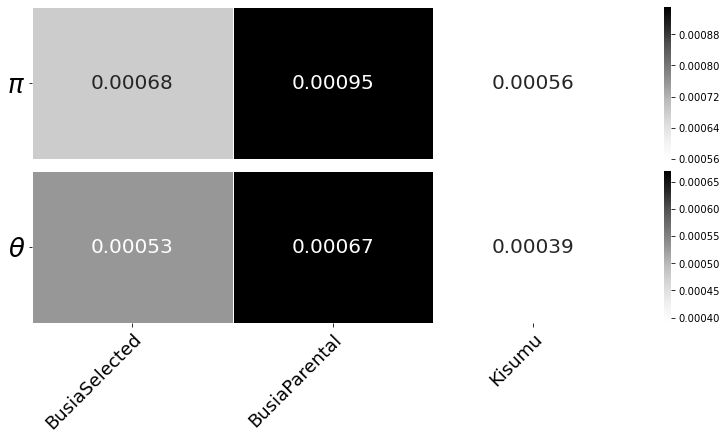

In [118]:
plotTwoRectangular(pi.T, True, theta.T, True, path=None, cmap="Greys", figsize=[10,6], annotFontsize=20, ytickfontsize=26, ylab="", ratio=[2])

### Karyotype average freq

In [4]:
invs = ["2La", "2Rb"]

In [9]:
ploidy = 10

karyo = {}
for inv in invs:
    df = pd.read_csv(f"../../results/karyotype/{inv}.Ag_Busia.karyo.txt", sep="\t")
    #df = df.rename(columns={0:'Sample', 1:'KaryoScore', 2:'n_SNPtags'})
    #df[inv] = df['KaryoScore']/ploidy
    
    karyo[inv] = df[['Sample', inv]]

karyo = pd.concat(karyo.values(), axis=1).T.drop_duplicates().T.set_index("Sample")
karyo = karyo.T.astype("float64").round(3)

df = karyo.T.reset_index()
df['Sample'] = df['Sample'].str.strip('123456')
df = df.groupby("Sample").agg('mean').T

karyo = karyo.astype('float64').round(2)
df = df.astype('float64').round(2)

#plotRectangular(karyo, path="../../results/karyotype/karyoHeatmap.png", ylab='Inversion', figsize=[10,len(invs)], title="Karyotypes")
#plotRectangular(df, path="../../results/karyotype/karyoOverallHeatmap.png", ylab='Inversion', cbar=False, figsize=[2,len(invs)], rotate=True)

In [10]:
plotTwoRectangular(karyo, True, df, True, path="../../results/karyotype/all.inversions.png", figsize=[20,4], ylab='Inversion', annotFontsize=26)

In [283]:
import scipy
import itertools

In [274]:
df2 = karyo.T.reset_index()

df2['Sample'] = df2['Sample'].str.strip('123456')

In [292]:
for inv in invs:
    print(inv)
    for x,y in itertools.combinations(df2['Sample'].unique(), 2):
        print(x,y)
        a = scipy.stats.mannwhitneyu(x=df2.query("Sample == @x")[inv], y= df2.query("Sample == @y")[inv])
        print(a.pvalue*6)


2La
BusRes BusSus
0.01409309246799021
BusRes Kis
0.0383420142685572
BusSus Kis
0.32945822644571165
2Rb
BusRes BusSus
1.3969771991508462
BusRes Kis
0.041765739984431866
BusSus Kis
0.041765739984431866


### Fst per Gene heatmap

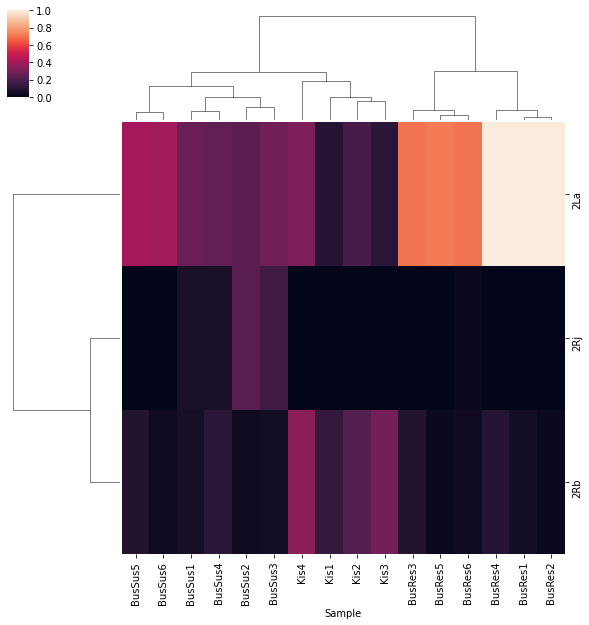

In [154]:
sns.clustermap(karyo)

In [273]:
fst = pd.read_csv("../../results/variantAnalysis/selection/FstPerGene.tsv", sep="\t")
fst = fst.set_index("GeneName").filter(like="zFst").dropna()

In [275]:
fst = fst.sort_values(by="BusiaSus_BusiaRes_zFst").reset_index()
fst.query("GeneName == 'CYP6P4'")

,GeneName,Kisumu_BusiaSus_zFst,BusiaSus_BusiaRes_zFst,Kisumu_BusiaRes_zFst
1022,CYP6P4,0.41543,0.024887,0.398656


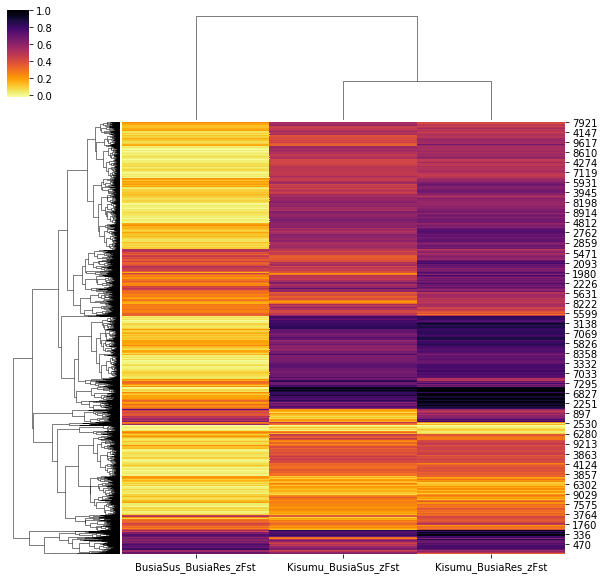

In [179]:
sns.clustermap(fst, cmap='inferno_r')

## snp frequency and expression level

In [3]:
import allel
import statsmodels.api as sm

In [4]:
gff = allel.gff3_to_dataframe("../../resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3", attributes=['ID'])
gff = gff.query("type == 'gene'")

In [5]:
gff['size'] = gff['end'] - gff['start']

In [6]:
fst = pd.read_csv("../../results/variantAnalysis/selection/FstPerGene.tsv", sep="\t")
fst = fst.set_index("GeneID").dropna()

countsPerGene = pd.read_csv("../../results/quant/rawcounts.tsv",sep="\t").set_index("GeneID").sum(axis=1)

In [7]:
df = fst[['nSNPs']]

df2 = pd.DataFrame(countsPerGene).rename(columns={0:"counts"})

df = df.merge(df2, left_index=True, right_index=True).reset_index()
df.head(2)

,GeneID,nSNPs,counts
0,AGAP004696,63,150113
1,AGAP004707,18,42014


In [8]:
df = gff.rename(columns={'ID': 'GeneID'})[['GeneID', 'size']].merge(df)

In [9]:
df.sort_values(by='size').head(3)

,GeneID,size,nSNPs,counts
666,AGAP004632,281,3,706
121,AGAP006000,314,9,2925
181,AGAP006506,344,13,63372


<AxesSubplot:xlabel='counts', ylabel='nSNPs'>

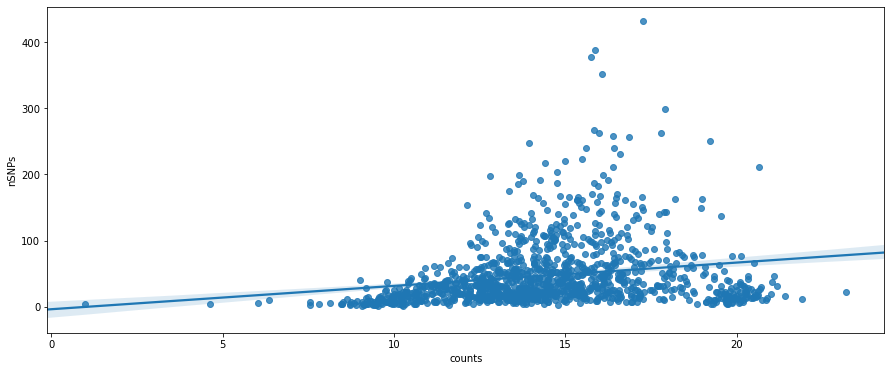

In [10]:
plt.figure(figsize=[15,6])
sns.regplot(y=df['nSNPs'], x=np.log2(df['counts']))

In [14]:
Y = np.log2(df['nSNPs'])
X = df[['counts', 'size']]
X = X.apply(np.log2)
X = sm.add_constant(X)

model = sm.GLM(Y,X, family=sm.families.Gaussian())
res = model.fit()
p = res.params
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  nSNPs   No. Observations:                 1188
Model:                            GLM   Df Residuals:                     1185
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.0967
Method:                          IRLS   Log-Likelihood:                -1739.1
Date:                Wed, 23 Mar 2022   Deviance:                       1299.6
Time:                        15:37:04   Pearson chi2:                 1.30e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2648      0.259     -8.749      0.000      -2.772      -1.757
counts         0.1352      0.011     12.596      0.000       0.114       0.156
size           0.4526      0.017     25.885      0.000       0.418       0.487
==============================================================================
"""

In [15]:
with open('../../results/GLM_SNPcountPerGene_summary.txt', 'w') as fh:
    fh.write(res.summary().as_text())

In [17]:
res

In [117]:
p['con']

const    -2.451484
counts    0.146172
size      0.466071
dtype: float64

In [116]:
p['counts']

0.14617161092853415

In [115]:
p['size']

0.46607139805532877

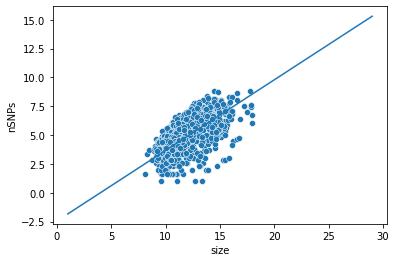

In [119]:
# generate x-values for your regression line (two is sufficient)
x = np.arange(1, 30)
# scatter-plot data
ax = sns.scatterplot(x=X['size'], y=Y)

# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + (p['counts'] + p['size']) * x)
plt.show()